# baseline-plots

## Generating plots with baseline parameters

In this Notebook, we generate plots with the baseline paramters used by Maaten in the 2008 t-SNE paper, for the purpose of visual comparison with the optimized plots.

## Tools & Libraries

We use **`Python`**. The following modules are used:

* **pandas:** reading, writing and manipulating data.
* **numpy:** vectorized calculations and other relevant math functions.
* **scipy:** functions for scientific purposes. Great statistics content.
* **matplotlib & seaborn:** data visualization.
* **sklearn:** comprehensive machine learning libraries.
* **hyperopt:** random search and TPE for hyperparameter optimization.
* **BayesianOptimization:** Gaussian Processes.

In [1]:
# opening up a console as the notebook starts
#%qtconsole

# making plots stay on the notebook (no extra windows!)
%matplotlib inline

# show figures with highest resolution 
%config InlineBackend.figure_format = 'retina'

# changing working directory
import os
os.chdir('C:\\Users\\Guilherme\\Documents\\TCC\\tsne-optim')

# importing modules
import pandas as pd
import numpy as np
import scipy
import matplotlib.pyplot as plt
import seaborn as sns
import png, array
from sklearn.manifold import TSNE
from sklearn.decomposition import PCA
from bayes_opt import BayesianOptimization
from hyperopt import fmin, rand, tpe, hp, STATUS_OK, Trials
from hdbscan import HDBSCAN
from sklearn.metrics import adjusted_mutual_info_score
from scipy.stats import spearmanr
from sklearn.metrics.pairwise import euclidean_distances

### Baseline parameters

Let us define the baseline set of parameters.

In [2]:
# set of hyperparameters definition - baseline #

space_base = {'perplexity': 30,
              'early_exaggeration': 4.0,
              'learning_rate': 100,
              'n_iter': 1000,
              'angle': 0.5,
              'pca_dims': 30,
              'whitening_flag': False}

## Target function

Let us replicate the optimization target function to create the plots. We supress the random states definitions to allow for random results.

In [3]:
# defining cost function: KL divergence #

# the function takes a search space sample as parameter #
def optim_target(data, perplexity, early_exaggeration, learning_rate, n_iter, angle, pca_dims, whitening_flag, n_runs=3):    
    
    # setting random seed
    #np.random.seed(42)
    
    # store target info
    target_var = data['TARGET']; data = data.drop('TARGET', axis=1)
    
    # HDBSCAN to compute clusters on high dimensional space
    # HDBSCAN(min_cluster_size=10, min_samples=1, allow_single_cluster=True)
    clusterer_highd = HDBSCAN(min_cluster_size=10, min_samples=1, allow_single_cluster=True)

    # clustering points
    cluster_assign_highd = clusterer_highd.fit_predict(PCA(n_components=100).fit_transform(data))        
    
    # PCA first to reduce data
    reducer = PCA(n_components=pca_dims, whiten=whitening_flag)
    
    # reducing
    reduced_data = reducer.fit_transform(data)
    
    # let us run t-SNE 5 times and get the best KL div #
    
    # divergence accumulator, initialize with +infinity
    KL_div = np.inf
    
    # loop for each t-SNE run
    for i in range(n_runs):
        
        # configuring t-SNE
        embedder = TSNE(perplexity=perplexity, early_exaggeration=early_exaggeration,
                        learning_rate=learning_rate, n_iter=n_iter,
                        angle=angle, random_state=i)
        
        # fitting
        temp_data = embedder.fit_transform(reduced_data)
    
        # KL divergence result after optimization
        temp_div = embedder.kl_divergence_
        
        # if smaller than last experiment, update
        if temp_div < KL_div:
            
            # updating values
            KL_div = temp_div
            embedded_data = temp_data
    
    # data frame form embedded_data
    embedded_data = pd.DataFrame({'x': zip(*embedded_data)[0], 'y': zip(*embedded_data)[1]})
    
    # computing ajusted mutual information over clusterings #

    # HDBSCAN to compute clusters on embedded space
    clusterer_lowd = HDBSCAN(min_cluster_size=10, min_samples=1, allow_single_cluster=True)

    # clustering points - low-dim
    cluster_assign_lowd = clusterer_lowd.fit_predict(embedded_data)

    # ajusted mutual info score
    AMI_score = adjusted_mutual_info_score(cluster_assign_highd, cluster_assign_lowd)
    
    # ajusted mutual info on target and dimensions
    AMI_target_highd = adjusted_mutual_info_score(target_var, cluster_assign_highd)
    AMI_target_lowd = adjusted_mutual_info_score(target_var, cluster_assign_lowd)

    # computing global geometry #
    
    # treating empty centers errors
    try:
        # centers on high dimensional space
        data['assignment'] = cluster_assign_highd; c_groups = data.groupby('assignment').mean()
        centers_highd = [np.array(c_groups.iloc[i,:]) for i in c_groups.index if not i == -1]

        # distances on high dimensional space
        dists_highd = euclidean_distances(centers_highd)
        closest_highd = [np.argsort(dists_highd[:,i])[1:] for i in range(dists_highd.shape[0])]
        closest_highd_df = pd.DataFrame(np.matrix(closest_highd))

        # centers on low dimensional space
        embedded_data['assignment'] = cluster_assign_highd; c_groups = embedded_data.groupby('assignment').mean()
        centers_lowd = [np.array(c_groups.iloc[i,:]) for i in c_groups.index if not i == -1]

        # distances on high dimensional space
        dists_lowd = euclidean_distances(centers_lowd)
        closest_lowd = [np.argsort(dists_lowd[:,i])[1:] for i in range(dists_lowd.shape[0])]
        closest_lowd_df = pd.DataFrame(np.matrix(closest_lowd))

        # correlations
        rank_order_cor = [spearmanr(closest_lowd_df.iloc[i,:], closest_highd_df.iloc[i,:]).correlation for i in closest_lowd_df.index]
        rank_order_cor_score = np.mean(rank_order_cor)
    
    # lowest value for rank-order corr if error
    except ValueError:
        rank_order_cor_score = -1.0
    
    # organizing parameters to return
    params = {'perplexity': perplexity,
              'early_exaggeration': early_exaggeration,
              'learning_rate': learning_rate,
              'n_iter': n_iter,
              'angle': angle,
              'pca_dims': pca_dims,
              'whitening_flag': whitening_flag}
    
    # adding target variable to embedded data
    embedded_data.loc[:,'target'] = target_var
    
    # printing results
    print 'KL divergence:', KL_div, '| AMI score:', AMI_score
    print 'AMI target-highd:', AMI_target_highd, '| AMI target-lowd:', AMI_target_lowd
    print 'Rank-order correlation:', rank_order_cor_score
    print 'Parameters:', params
    print ' '

    # returning values
    return KL_div, AMI_score, AMI_target_highd, AMI_target_lowd, rank_order_cor_score, embedded_data, params

## Hyperopt wrapper

Let us use the hyperopt wrapper defined in the other notebooks since it has a nice saving mechanism for the plots 

In [4]:
# wrapper for hyperopt #

# hyperopt minimizes functions, so our target value is set
class hp_wrapper:
    
    def __init__(self, data, save_path=None, n_runs=5):
        self.data = data
        self.save_path = save_path
        self.n_runs = n_runs
    
    def target(self, space):
        
        # pre-processing space
        space['pca_dims'] = int(space['pca_dims'])
        space['n_iter'] = int(space['n_iter'])
        
        # trying to ignore errors
        try:        
            # running target function
            kl_div, ami, ami_th, ami_tl, spearman, embed, params = optim_target(self.data, n_runs=self.n_runs, **space)    

            # if we want to save
            if not self.save_path == None:

                # creating path if necessary
                if not os.path.exists(self.save_path):
                    os.makedirs(self.save_path)

                # save name of the plot
                save_name = str(max([int(e.split('.')[0]) for e in os.listdir(self.save_path)]+[-1]) + 1) + '.png'

                # title of the plot
                plot_title = 'KL divergence: {0:.3f} | AMI score: {1:.3f} | AMI target-highd:'.format(kl_div, ami) + \
                             '{0:.3f} | AMI target-lowd: {1:.3f} | Rank-order correlation: {2:.3f}'.format(ami_th, ami_tl, spearman)

                # subtitle showing parameters
                subtitle = '{}'.format(params)

                # creating plot
                fig = sns.lmplot(x='x', y='y', hue='target', data=embed, fit_reg=False, size=9, aspect=1.6); 
                plt.title(plot_title); plt.xlabel(subtitle)

                # saving
                fig.savefig(os.path.join(self.save_path,save_name))
                
                # do not show plot on jupyter
                plt.close()

            # a dict with 'loss' and 'status' is required
            return {'loss': -ami,
                    'status': STATUS_OK,
                    'parameters': params,
                    'embedding': embed}
        
        # catching exception
        except Exception as e:
            print 'An Error occurred:', e
            
            # a dict with 'loss' and 'status' is required
            return {'loss': 0,
                    'status': 'fail',
                    'parameters': space,
                    'embedding': 'error'}


### Saving plots for each dataset

Let us load each dataset and save 10 plots with the same parameters for each.

In [ ]:
# defining dataset names
df_names = ['well_sep', 'well_sep_noise', 'gaussian_noise', 'topology', 'coil_20', 'olivetti-faces']

# loop for each dataset
for df_name in df_names:
    
    # path for loading data
    path = 'data/final/{}.csv'.format(df_name.replace('_','-'))
    df = pd.read_csv(path)
    
    # creating wrapper object for saving
    fig_path = 'vis/baseline_plots/{}'.format(df_name)
    task = hp_wrapper(df, save_path=fig_path, n_runs=1)
    
    # let us generate 5 figures for each dataset
    for i in range(5):
        
        # running t-SNE and saving
        task.target(space_base);

In [9]:
# path for loading data
path = 'data/final/coil-20.csv'
df = pd.read_csv(path)

# creating wrapper object for saving
fig_path = 'vis/coil-20-legendado.png'
task = hp_wrapper(df, save_path=fig_path, n_runs=1)

# running t-SNE
out = task.target(space_base)

KL divergence: 1.87976408005 | AMI score: 0.667843391114
AMI target-highd: 0.894409781412 | AMI target-lowd: 0.65840237944
Rank-order correlation: 0.0671984805318
Parameters: {'whitening_flag': False, 'n_iter': 1000, 'pca_dims': 30, 'angle': 0.5, 'learning_rate': 100, 'early_exaggeration': 4.0, 'perplexity': 30}
 


(-8, 8)

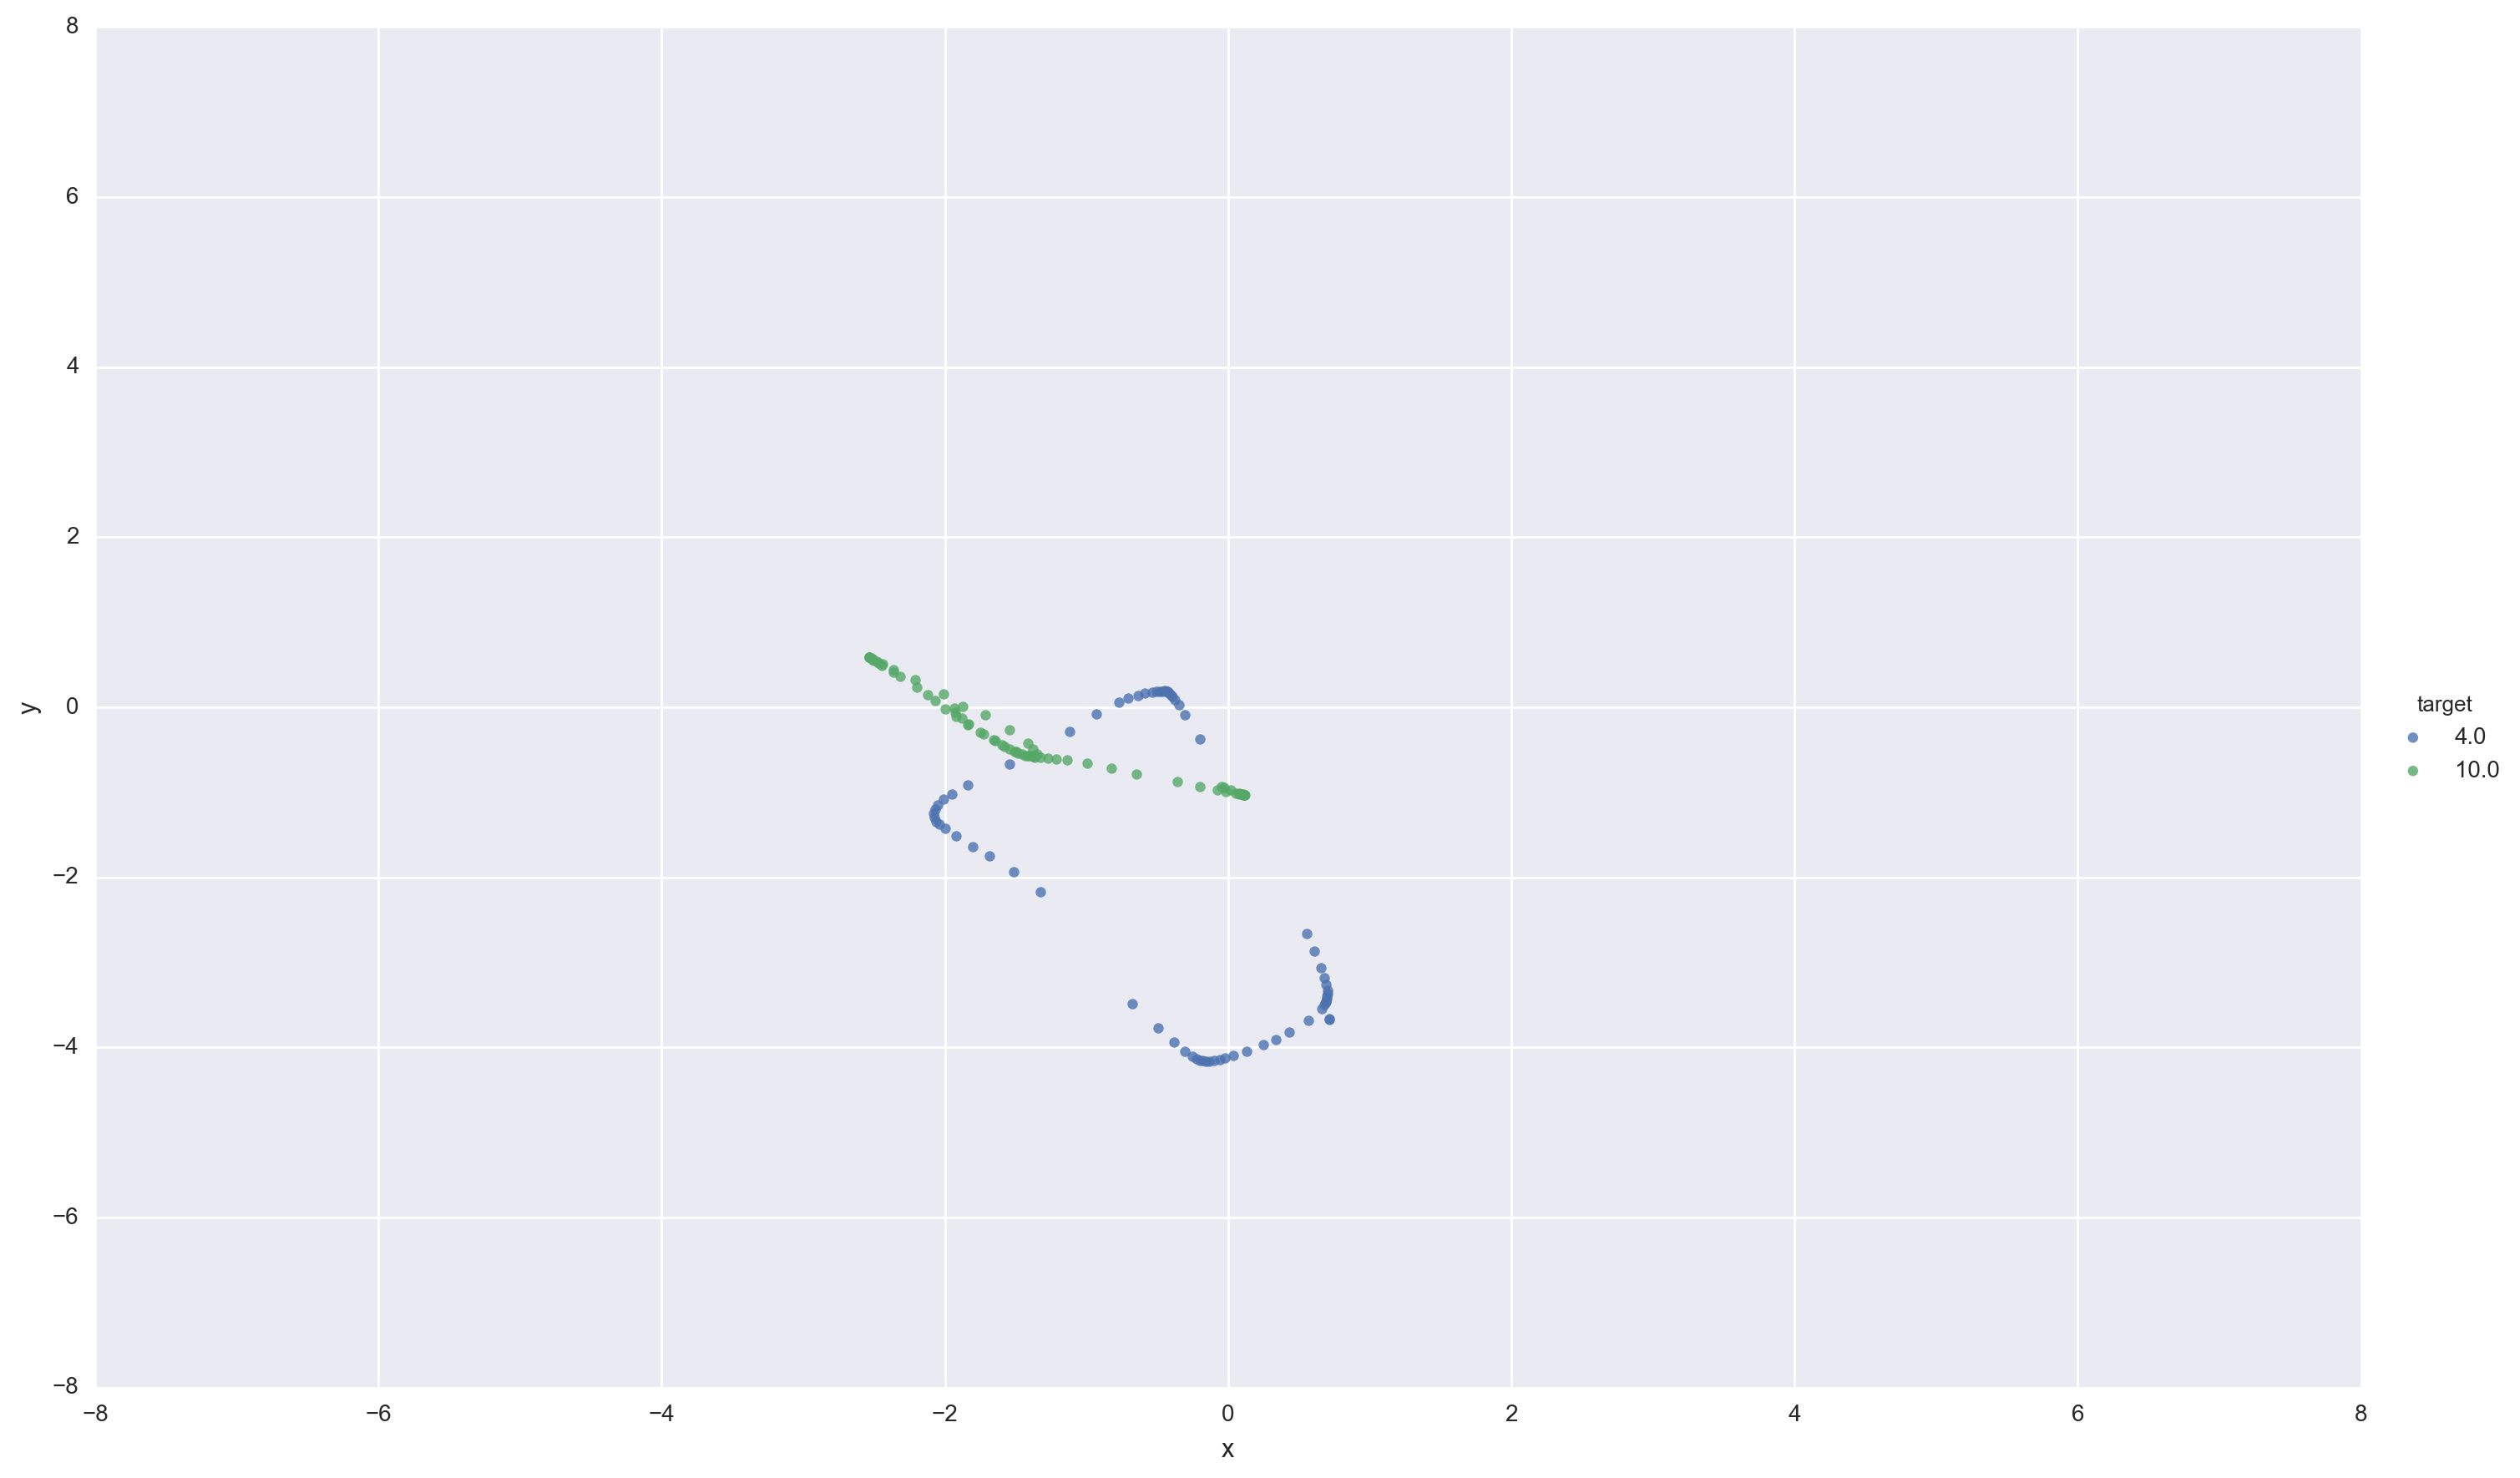

In [47]:
embed = out['embedding']; 
#embed = embed.loc[[e in [6,3,19] for e in embed['target']],:]
embed = embed.loc[[e in [4, 10] for e in embed['target']],:]


# creating plot
fig = sns.lmplot(x='x', y='y', hue='target', data=embed, fit_reg=False, size=9, aspect=1.6); 
plt.xlim(-8,8); plt.ylim(-8,8)